# Assigment 2

## The assignment is divided into programming and mathematical questions. Both of them are given in this notebook.

## Programming questions: I am giving you a template that you can use to write your code. Description of the questions is integrated in the comments.

## Upload your code on Learn dropbox and submit pdfs of the code and answers to the mathematical questions on Crowdmark.

## -----------------------------------------------------------------------------------------------------------

## Load modules

In [1]:
# !pip install numpy, scipy, scikit-image, skimage, matplotlib

import matplotlib.pyplot as plt

from skimage.color import rgb2gray
from skimage import data
from skimage.transform import resize

# Numpy is useful for handling arrays and matrices.
import numpy as np

/home/oymamatt/anaconda3/envs/hc37/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


## Load image

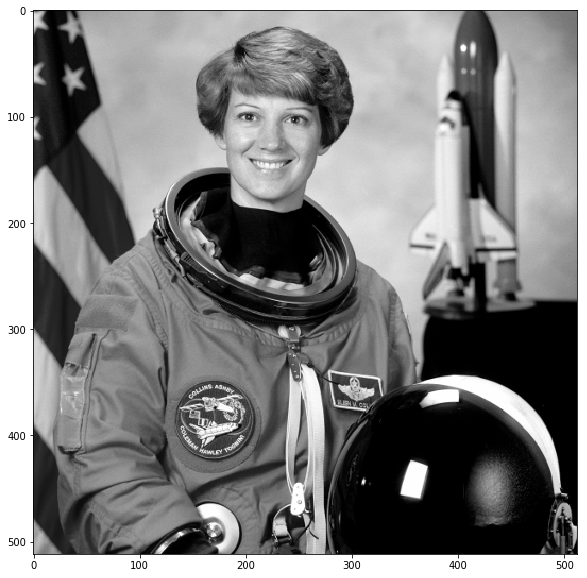

In [2]:
img = data.astronaut()
img = rgb2gray(img)*255 # convert to gray and change scale from (0,1) to (0,255).

n = img.shape[0]
m = n

plt.figure(1, figsize=(10, 10))
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

## Compute the differences operators here. Use your code from Assignment 1.

In [3]:
# You will need these three methods to construct sparse differences operators.
# If you do not use sparse operators you might have scalability problems.
from scipy.sparse import diags
from scipy.sparse import kron
from scipy.sparse import identity
from scipy.sparse.linalg import eigsh
from scipy.sparse import csr_matrix
from scipy import real

# Use your code from Assignment 1. 
# Make sure that you compute the right D_h and D_v matrices.

J = diags(diagonals=[
    [-1.0] * n,
    [1.0] * (n-1)
], offsets=[0, 1])

I = identity(n=n)

# Forward Horizontal Difference
D_h = kron(J, I)

# Forward Vertical Difference
D_v = kron(I, J)

D = D_h + 1j * D_v

D_s = (D.H).dot(D)


def matrix_p2_norm(A):
    eig_val = eigsh((A.H).dot(A), return_eigenvectors=False, tol=0.001, k=1)
    return np.sqrt(eig_val).sum()

def vector_norm(x):
    return np.sqrt(real((x.H).dot(x))).sum()

def G(lamb, realize=True):
    return lamb * (real(D_s) if realize else D_s) + identity(n*m)

# The denoising objective function
def f(lamb, x, z_n):
    return real(0.5 * lamb * (vector_norm(D.dot(x)) ** 2.0) + 0.5 * vector_norm(x - z_n) ** 2.0)

# The denoising objective function gradient
def grad_f(lamb, x, z_n):
    return G(lamb).dot(x) - z_n

## Add noise to the image

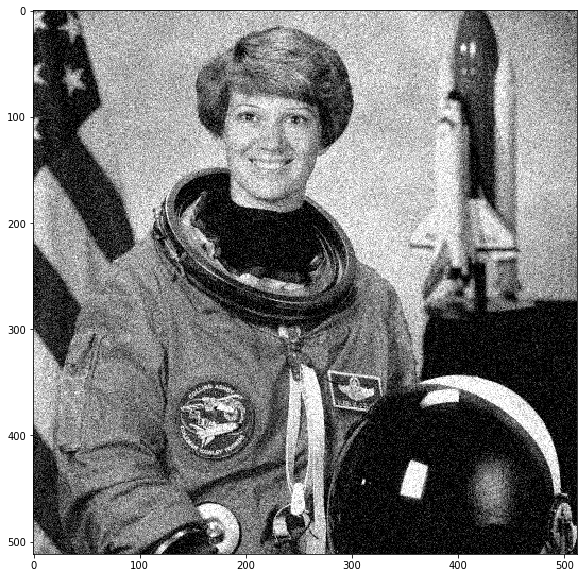

In [5]:
mean_ = 0
standard_deviation = 30
dimensions = (n,n)

noise = np.random.normal(mean_,standard_deviation,dimensions)

noisy_image = img + noise
noisy_image_vec = csr_matrix(noisy_image.T.ravel()).T

plt.figure(1, figsize=(10, 10))
plt.imshow(noisy_image, cmap='gray', vmin=0, vmax=255)
plt.show()

 ## Question 1: implement gradient descent using the Lipschitz constant as the step-size for the denoising problem. Use eigsh method from scipy.sparse.linalg to compute the Lipschitz constant. Marks: 10

In [6]:
def gradient_descent_lip(x0, epsilon, lambda_, max_iterations):
    # x0: is the initial guess for the x variables
    # epsilon: is the termination tolerance parameter
    # lambda_: is the regularization parameter of the denoising problem.
    # max_iterations: is the maximum number of iterations that you allow the algorithm to run.

    # Write your code here.
    L = matrix_p2_norm(G(lamb=lambda_))
    print(f"Lipschitz Constant = {L}")
    x_updated = x0.copy()
    f_vals = []
    norm_vals = []
    for i in range(1, max_iterations+1):
        current_grad = grad_f(lamb=lambda_, x=x_updated, z_n=noisy_image_vec)
        current_grad_norm = vector_norm(current_grad)
        if current_grad_norm <= epsilon:
            break
        norm_vals.append(current_grad_norm)
        f_vals.append(f(lamb=lambda_, x=x_updated, z_n=noisy_image_vec))
        x_updated = x_updated - (1.0 / L) * current_grad
        f_diff = (f_vals[-1] - f_vals[-2]) if len(f_vals) > 1 else None
        grad_diff = (norm_vals[-1] - norm_vals[-2]) if len(norm_vals) > 1 else None
        print(f"Step = {i}: Function = {f_vals[-1]}, Function Diff. =  {f_diff}, Grad. Norm = {norm_vals[-1]}, Grad. Diff. = {grad_diff}")
    return x_updated, np.array(f_vals)

## Call Gradient Descent

In [7]:
# Initialize parameters of gradient descent.
lambda_ = 4
epsilon = 1.0e-2
max_iterations = 2000

# Set x0 equal to the vectorized noisy image.
# Write your code here.
optimized_gd_lip, f_vals_lip = gradient_descent_lip(x0=noisy_image_vec, 
                                                    lambda_=lambda_, 
                                                    epsilon=epsilon, 
                                                    max_iterations=max_iterations)

Lipschitz Constant = 32.9973027514001
Step = 1: Function = 2131058792.1455843, Function Diff. =  None, Grad. Norm = 281469.2459755225, Grad. Diff. = None
Step = 2: Function = 567792190.0083187, Function Diff. =  -1563266602.1372657, Grad. Norm = 101721.42679047752, Grad. Diff. = -179747.81918504497
Step = 3: Function = 331131084.7496567, Function Diff. =  -236661105.258662, Grad. Norm = 54648.45244934803, Grad. Diff. = -47072.97434112949
Step = 4: Function = 258083695.52489254, Function Diff. =  -73047389.22476414, Grad. Norm = 34684.642859026826, Grad. Diff. = -19963.8095903212
Step = 5: Function = 227229569.038472, Function Diff. =  -30854126.486420542, Grad. Norm = 24570.946236570682, Grad. Diff. = -10113.696622456144
Step = 6: Function = 211200405.8239566, Function Diff. =  -16029163.214515388, Grad. Norm = 18767.057557762026, Grad. Diff. = -5803.888678808657
Step = 7: Function = 201618775.6796133, Function Diff. =  -9581630.144343317, Grad. Norm = 15082.584915089747, Grad. Diff. =

Step = 58: Function = 173379617.48986372, Function Diff. =  -6665.157375752926, Grad. Norm = 453.3627896569107, Grad. Diff. = -20.856851242347318
Step = 59: Function = 173373524.99137324, Function Diff. =  -6092.498490482569, Grad. Norm = 433.52920802228374, Grad. Diff. = -19.833581634626967
Step = 60: Function = 173367953.25026378, Function Diff. =  -5571.741109460592, Grad. Norm = 414.66109624173606, Grad. Diff. = -18.86811178054768
Step = 61: Function = 173362855.37076455, Function Diff. =  -5097.879499226809, Grad. Norm = 396.70450987120734, Grad. Diff. = -17.956586370528726
Step = 62: Function = 173358188.94471157, Function Diff. =  -4666.4260529875755, Grad. Norm = 379.6090532886648, Grad. Diff. = -17.09545658254251
Step = 63: Function = 173353915.5914049, Function Diff. =  -4273.353306651115, Grad. Norm = 363.3276019909867, Grad. Diff. = -16.28145129767813
Step = 64: Function = 173350000.54836297, Function Diff. =  -3915.043041944504, Grad. Norm = 347.81605054345215, Grad. Diff.

Step = 115: Function = 173305957.335114, Function Diff. =  -64.43278467655182, Grad. Norm = 44.81194161053031, Grad. Diff. = -1.7333456980572137
Step = 116: Function = 173305897.61012417, Function Diff. =  -59.7249898314476, Grad. Norm = 43.14578749215052, Grad. Diff. = -1.6661541183797937
Step = 117: Function = 173305842.24219683, Function Diff. =  -55.367927342653275, Grad. Norm = 41.54408325183558, Grad. Diff. = -1.6017042403149375
Step = 118: Function = 173305790.9073243, Function Diff. =  -51.334872514009476, Grad. Norm = 40.004206535380256, Grad. Diff. = -1.5398767164553249
Step = 119: Function = 173305743.30612674, Function Diff. =  -47.60119757056236, Grad. Norm = 38.52364871188896, Grad. Diff. = -1.4805578234912957
Step = 120: Function = 173305699.1619302, Function Diff. =  -44.144196540117264, Grad. Norm = 37.10000954060398, Grad. Diff. = -1.4236391712849823
Step = 121: Function = 173305658.2190048, Function Diff. =  -40.94292539358139, Grad. Norm = 35.730992111974295, Grad. 

Step = 172: Function = 173305138.36093745, Function Diff. =  -0.9904303252696991, Grad. Norm = 5.565766896911597, Grad. Diff. = -0.2016529138687213
Step = 173: Function = 173305137.43854445, Function Diff. =  -0.9223929941654205, Grad. Norm = 5.371313031631395, Grad. Diff. = -0.19445386528020236
Step = 174: Function = 173305136.57946268, Function Diff. =  -0.8590817749500275, Grad. Norm = 5.183794502858988, Grad. Diff. = -0.18751852877240704
Step = 175: Function = 173305135.77931285, Function Diff. =  -0.8001498281955719, Grad. Norm = 5.002957571392588, Grad. Diff. = -0.18083693146640023
Step = 176: Function = 173305135.03400016, Function Diff. =  -0.7453126907348633, Grad. Norm = 4.8285580786781885, Grad. Diff. = -0.17439949271439925
Step = 177: Function = 173305134.33973852, Function Diff. =  -0.6942616403102875, Grad. Norm = 4.660361070752852, Grad. Diff. = -0.1681970079253361
Step = 178: Function = 173305133.69298738, Function Diff. =  -0.6467511355876923, Grad. Norm = 4.4981404376

Step = 229: Function = 173305125.0630107, Function Diff. =  -0.01844373345375061, Grad. Norm = 0.7601561540606742, Grad. Diff. = -0.02660342256895365
Step = 230: Function = 173305125.04579678, Function Diff. =  -0.017213910818099976, Grad. Norm = 0.7344637803470536, Grad. Diff. = -0.025692373713620542
Step = 231: Function = 173305125.02972388, Function Diff. =  -0.016072899103164673, Grad. Norm = 0.7096507771215536, Grad. Diff. = -0.024813003225500063
Step = 232: Function = 173305125.0147178, Function Diff. =  -0.015006095170974731, Grad. Norm = 0.6856865879590415, Grad. Diff. = -0.023964189162512084
Step = 233: Function = 173305125.00071383, Function Diff. =  -0.014003962278366089, Grad. Norm = 0.662541737747873, Grad. Diff. = -0.02314485021116852
Step = 234: Function = 173305124.9876323, Function Diff. =  -0.013081520795822144, Grad. Norm = 0.6401877935689435, Grad. Diff. = -0.02235394417892944
Step = 235: Function = 173305124.97542328, Function Diff. =  -0.012209028005599976, Grad. 

Step = 283: Function = 173305124.80920947, Function Diff. =  -0.0004725158214569092, Grad. Norm = 0.12104410926206481, Grad. Diff. = -0.00415033046787007
Step = 284: Function = 173305124.8087735, Function Diff. =  -0.0004359781742095947, Grad. Norm = 0.11703256427420064, Grad. Diff. = -0.004011544987864171
Step = 285: Function = 173305124.80836597, Function Diff. =  -0.0004075169563293457, Grad. Norm = 0.11315511635777899, Grad. Diff. = -0.003877447916421653
Step = 286: Function = 173305124.80798888, Function Diff. =  -0.0003770887851715088, Grad. Norm = 0.10940723740163286, Grad. Diff. = -0.0037478789561461306
Step = 287: Function = 173305124.8076267, Function Diff. =  -0.00036218762397766113, Grad. Norm = 0.10578455403318734, Grad. Diff. = -0.0036226833684455118
Step = 288: Function = 173305124.8072967, Function Diff. =  -0.0003300011157989502, Grad. Norm = 0.10228284225549818, Grad. Diff. = -0.0035017117776891676
Step = 289: Function = 173305124.80698347, Function Diff. =  -0.000313

Step = 337: Function = 173305124.80267018, Function Diff. =  -1.1235475540161133e-05, Grad. Norm = 0.019869442534650863, Grad. Diff. = -0.0006717161605472415
Step = 338: Function = 173305124.80266115, Function Diff. =  -9.03010368347168e-06, Grad. Norm = 0.019219830790958722, Grad. Diff. = -0.0006496117436921404
Step = 339: Function = 173305124.80264768, Function Diff. =  -1.3470649719238281e-05, Grad. Norm = 0.01859159077271961, Grad. Diff. = -0.0006282400182391137
Step = 340: Function = 173305124.80263782, Function Diff. =  -9.864568710327148e-06, Grad. Norm = 0.01798401427767355, Grad. Diff. = -0.0006075764950460583
Step = 341: Function = 173305124.8026258, Function Diff. =  -1.2010335922241211e-05, Grad. Norm = 0.017396416770279664, Grad. Diff. = -0.000587597507393886
Step = 342: Function = 173305124.8026183, Function Diff. =  -7.510185241699219e-06, Grad. Norm = 0.01682813658051317, Grad. Diff. = -0.000568280189766495
Step = 343: Function = 173305124.80261064, Function Diff. =  -7

## Plot $$(f(x_k) - f(x^*)) / (f(x_0) - f(x^*))$$ vs the iteration counter k, where $$x^*$$ is the minimizer of the denoising problem, which you can compute by using spsolve, similarly to Assignment 1.

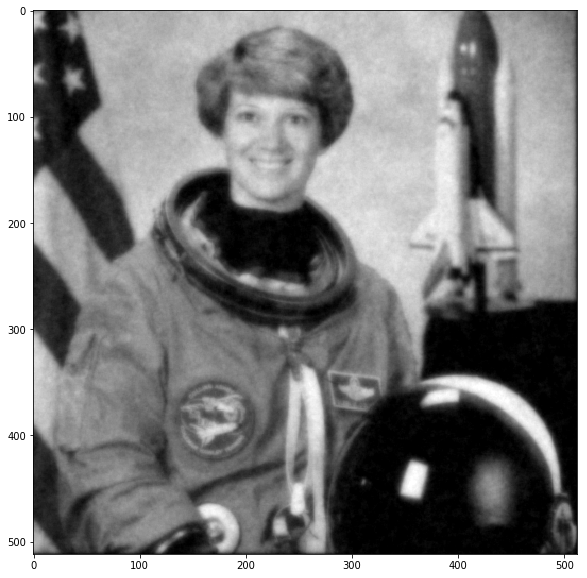

In [19]:
# Finding the optimal solution
from scipy.sparse.linalg import spsolve
x_star = spsolve(A=G(lamb=lambda_), b=noisy_image_vec)
f_star = f(lamb=lambda_, x=csr_matrix(x_star).T, z_n=noisy_image_vec)
denoised_image_star = x_star.reshape((m, n), order='F')
plt.figure(1, figsize=(10, 10))
plt.imshow(denoised_image_star, cmap='gray', vmin=0, vmax=255)
plt.show()

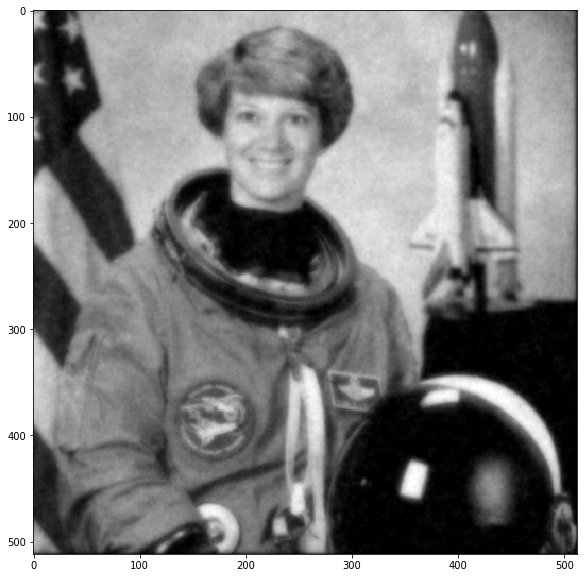

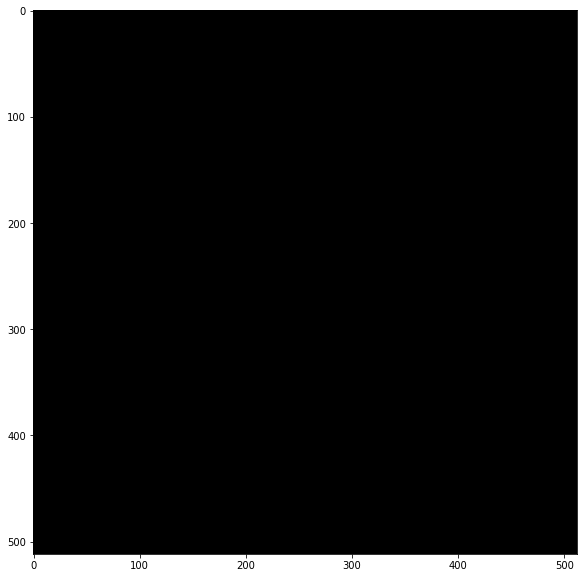

Abs. Diff. between GD-Lip and Linear Solver = 0.0001161284854731548


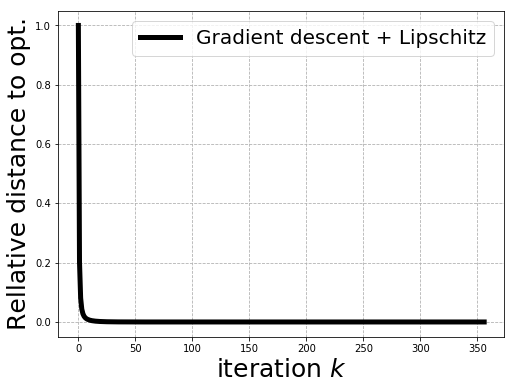

In [20]:
# Plot the relative objective function vs number of iterations. 
rate_lip = (f_vals_lip - f_star) / (f_vals_lip[0] - f_star)

denoised_image_gd_lip = optimized_gd_lip.toarray().reshape((m, n), order='F')
plt.figure(1, figsize=(10, 10))
plt.imshow(denoised_image_gd_lip, cmap='gray', vmin=0, vmax=255)
plt.show()

diff_lip = denoised_image_gd_lip - denoised_image_star
plt.figure(1, figsize=(10, 10))
plt.imshow(diff_lip, cmap='gray', vmin=0, vmax=255)
plt.show()

print(f"Abs. Diff. between GD-Lip and Linear Solver = {np.abs(diff_lip).max()}")

fig = plt.figure(figsize=(8, 6))
plt.plot(rate_lip, label=("Gradient descent + Lipschitz"), linewidth=5.0, color ="black")

plt.legend(prop={'size': 20},loc="upper right")
plt.xlabel("iteration $k$", fontsize=25)
plt.ylabel("Rellative distance to opt.", fontsize=25)
plt.grid(linestyle='dashed')
plt.show()

## Question 2: is there a "gap" between the practical convergence rate and the theoretical convergence rate? Note that the denoising objective function is strongly convex. Marks: 5


Answer


## Question 3: implement gradient descent with line-search for the denoising problem. Marks: 15

In [26]:
# Write a line-search-ls function here. 
# I am giving you a hint about what the input could be, but feel free to change the template. 
def line_search_ls(lambda_, x, f_x, grad_f_x):
    # lambda_: the regularization parameter
    # x: the current estimate of t=he variable
    # f_x: the value of the objective function at x
    # grad_f_x: the gradient of the objective function at x
    
    # Write your code here.
    alpha = 1.0
    while f(lamb=lambda_, x=x-alpha*grad_f_x, z_n=noisy_image_vec) >= f_x:
        alpha /= 2.0
    return alpha

# Write gradient descent + line-search here.
# I am giving you a hint about what the input could be, but feel free to change the template. 
def gradient_descent_ls(x0, epsilon, lambda_, max_iterations):
    # x0: is the initial guess for the x variables
    # epsilon: is the termination tolerance parameter
    # lambda_: is the regularization parameter of the denoising problem.
    # max_iterations: is the maximum number of iterations that you allow the algorithm to run.

    # Write your code here.
    x_updated = x0.copy()
    f_vals = []
    norm_vals = []
    for i in range(1, max_iterations+1):
        current_grad = grad_f(lamb=lambda_, x=x_updated, z_n=noisy_image_vec)
        current_grad_norm = vector_norm(current_grad)
        if current_grad_norm <= epsilon:
            break
        norm_vals.append(current_grad_norm)
        f_vals.append(f(lamb=lambda_, x=x_updated, z_n=noisy_image_vec))
        alpha = line_search_ls(lambda_=lambda_, x=x_updated, f_x=f_vals[-1], grad_f_x=current_grad)
        x_updated = x_updated - alpha * current_grad
        f_diff = (f_vals[-1] - f_vals[-2]) if len(f_vals) > 1 else None
        grad_diff = (norm_vals[-1] - norm_vals[-2]) if len(norm_vals) > 1 else None
        print(f"Step = {i}: alpha = {alpha}, Function = {f_vals[-1]}, Function Diff. =  {f_diff}, Grad. Norm = {norm_vals[-1]}, Grad. Diff. = {grad_diff}")
    return x_updated, np.array(f_vals)

## Call Gradient Descent with line-search

In [27]:
# Initialize parameters of gradient descent
lambda_ = 4
epsilon = 1.0e-2
max_iterations = 2000

# Set x0 equal to the vectorized noisy image.
# Write your code here.
optimized_gd_ls, f_vals_ls = gradient_descent_ls(x0=noisy_image_vec, 
                                                 lambda_=lambda_, 
                                                 epsilon=epsilon, 
                                                 max_iterations=max_iterations)

Step = 1: alpha = 0.0625 Function = 2131058792.1455843, Function Diff. =  None, Grad. Norm = 281469.2459755225, Grad. Diff. = None
Step = 2: alpha = 0.0625 Function = 742352460.4749476, Function Diff. =  -1388706331.6706367, Grad. Norm = 168846.42184232417, Grad. Diff. = -112622.82413319833
Step = 3: alpha = 0.0625 Function = 533652067.33416545, Function Diff. =  -208700393.14078212, Grad. Norm = 140229.81215165253, Grad. Diff. = -28616.60969067164
Step = 4: alpha = 0.0625 Function = 453865707.6627986, Function Diff. =  -79786359.67136687, Grad. Norm = 126782.00872832748, Grad. Diff. = -13447.803423325051
Step = 5: alpha = 0.0625 Function = 414154355.7517545, Function Diff. =  -39711351.91104406, Grad. Norm = 119367.67004650644, Grad. Diff. = -7414.338681821042
Step = 6: alpha = 0.0625 Function = 392283105.7484822, Function Diff. =  -21871250.003272295, Grad. Norm = 115117.49108678426, Grad. Diff. = -4250.17895972218
Step = 7: alpha = 0.0625 Function = 380080817.857072, Function Diff. 

Step = 53: alpha = 0.5 Function = 173305128.2591625, Function Diff. =  -6.62959960103035, Grad. Norm = 2.8474870707171815, Grad. Diff. = -17.803316250507795
Step = 54: alpha = 0.0625 Function = 173305127.24352527, Function Diff. =  -1.015637218952179, Grad. Norm = 10.63279422590465, Grad. Diff. = 7.785307155187469
Step = 55: alpha = 0.03125 Function = 173305127.16948166, Function Diff. =  -0.07404360175132751, Grad. Norm = 10.728977559517178, Grad. Diff. = 0.09618333361252773
Step = 56: alpha = 0.25 Function = 173305125.37170044, Function Diff. =  -1.797781229019165, Grad. Norm = 1.2053195655470896, Grad. Diff. = -9.523657993970088
Step = 57: alpha = 0.0625 Function = 173305125.26053098, Function Diff. =  -0.11116945743560791, Grad. Norm = 3.2267562056305272, Grad. Diff. = 2.0214366400834374
Step = 58: alpha = 0.0625 Function = 173305125.2001943, Function Diff. =  -0.060336679220199585, Grad. Norm = 3.028921936594087, Grad. Diff. = -0.19783426903644008
Step = 59: alpha = 0.0625 Functio

## Plot $$(f(x_k) - f(x^*)) / (f(x_0) - f(x^*))$$ vs the iteration counter k, where $$x^*$$ is the minimizer of the denoising problem, which you can compute by using spsolve, similarly to Assignment 1.

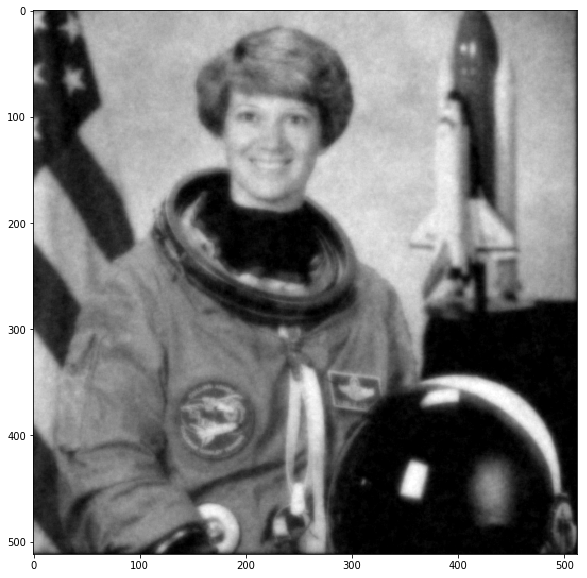

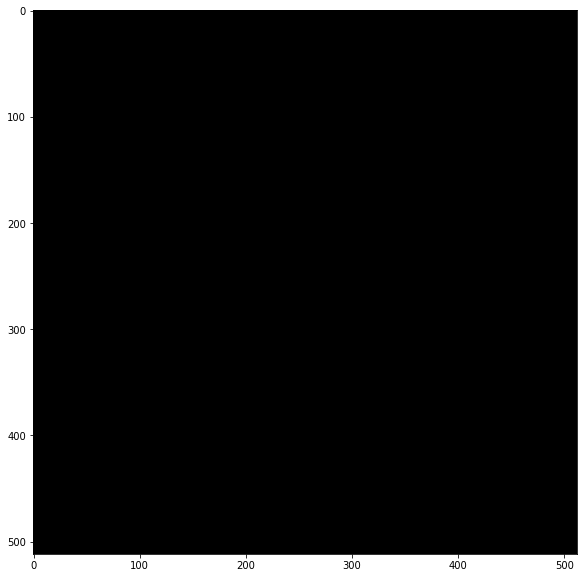

Abs. Diff. between GD-LS and Linear Solver = 7.157380474609454e-05


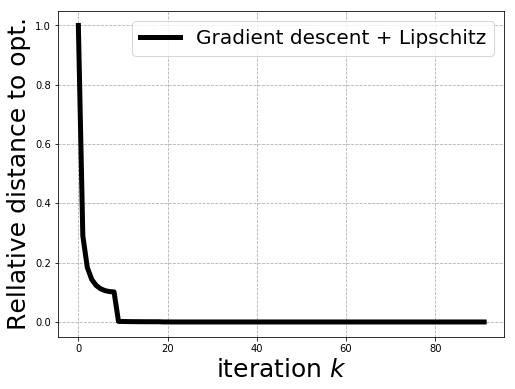

In [30]:
# Plot the relative objective function vs number of iterations. 

# Write your code here.

# Plot the rellative objective function vs number of iterations. 
rate_ls = (f_vals_ls - f_star) / (f_vals_ls[0] - f_star)

denoised_image_gd_ls = optimized_gd_ls.toarray().reshape((m, n), order='F')
plt.figure(1, figsize=(10, 10))
plt.imshow(denoised_image_gd_ls, cmap='gray', vmin=0, vmax=255)
plt.show()

diff_ls = denoised_image_gd_ls - denoised_image_star
plt.figure(1, figsize=(10, 10))
plt.imshow(diff_ls, cmap='gray', vmin=0, vmax=255)
plt.show()

print(f"Abs. Diff. between GD-LS and Linear Solver = {np.abs(diff_ls).max()}")

fig = plt.figure(figsize=(8, 6))
plt.plot(rate_ls, label=("Gradient descent + Lipschitz"), linewidth=5.0, color ="black")

plt.legend(prop={'size': 20},loc="upper right")
plt.xlabel("iteration $k$", fontsize=25)
plt.ylabel("Rellative distance to opt.", fontsize=25)
plt.grid(linestyle='dashed')
plt.show()

## Question 4: What is the advantage of using line-search to compute the step-size at each iteration instead of using constant step-sizes equal to 1/L? Where L is the Lipschitz constant. Is gradient descent with line-search faster than gradient descent with constant step-sizes in terms of running time? Is gradient descent with line-search faster than gradient descent with constant step-sizes in terms of running time when you add computation of the Lipschitz constant in the running time? Is gradient descent with line-search faster than gradient descent with constant step-sizes in terms of number of required iterations? Marks: 10

Question breakdown:

#### What is the advantage of using line-search to compute the step-size at each iteration instead of using constant step-sizes equal to 1/L? Where L is the Lipschitz constant. 

Computing the Lipschitz constant is an expensive operation especially on large number of parameters. So, the advantage is to skip that expensive operation.

#### Is gradient descent with line-search faster than gradient descent with constant step-sizes in terms of running time?

Answer

#### Is gradient descent with line-search faster than gradient descent with constant step-sizes in terms of running time when you add computation of the Lipschitz constant in the running time?

Answer

#### Is gradient descent with line-search faster than gradient descent with constant step-sizes in terms of number of required iterations?

Answer

## Questions 5: implement gradient descent with Armijo line-search for the denoising problem. Marks: 10

In [43]:
# Create a line-search-armijo function
def line_search_arm(lambda_, x, f_x, grad_f_x, norm_grad_f_x, gamma):
    # lambda_: the regularization parameter
    # x: the current estimate of t=he variable
    # f_x: the value of the objective function at x
    # grad_f_x: the gradient of the objective function at x
    # norm_grad_f_x: the norm of grad_f_x
    # gamma: parameter of Armijo line-search as was defined in the lectures.

    # Write your code here.
    alpha = 1.0
    while f(lamb=lambda_, x=x-alpha*grad_f_x, z_n=noisy_image_vec) > f_x - alpha * gamma * (norm_grad_f_x ** 2.0):
        alpha /= 2.0
    return alpha
    
def gradient_descent_arm(x0, epsilon, lambda_, max_iterations, gamma):
    # x0: is the initial guess for the x variables
    # epsilon: is the termination tolerance parameter
    # lambda_: is the regularization parameter of the denoising problem.
    # max_iterations: is the maximum number of iterations that you allow the algorithm to run.
    # gamma: parameter of Armijo line-search as was defined in the lectures.
    
    # Write your code here.
    x_updated = x0.copy()
    f_vals = []
    norm_vals = []
    for i in range(1, max_iterations+1):
        current_grad = grad_f(lamb=lambda_, x=x_updated, z_n=noisy_image_vec)
        current_grad_norm = vector_norm(current_grad)
        if current_grad_norm <= epsilon:
            break
        norm_vals.append(current_grad_norm)
        f_vals.append(f(lamb=lambda_, x=x_updated, z_n=noisy_image_vec))
        alpha = line_search_arm(lambda_=lambda_, x=x_updated, f_x=f_vals[-1], grad_f_x=current_grad, norm_grad_f_x=current_grad_norm, gamma=gamma)
        x_updated = x_updated - alpha * current_grad
        f_diff = (f_vals[-1] - f_vals[-2]) if len(f_vals) > 1 else None
        grad_diff = (norm_vals[-1] - norm_vals[-2]) if len(norm_vals) > 1 else None
        print(f"Step = {i}: alpha = {alpha}, Function = {f_vals[-1]}, Function Diff. =  {f_diff}, Grad. Norm = {norm_vals[-1]}, Grad. Diff. = {grad_diff}")
    return x_updated, np.array(f_vals)

## Call Gradient Descent with Armijo line search

In [59]:
# Initialize parameters of gradient descent
lambda_ = 4
epsilon = 1.0e-2
gamma = 0.13
max_iterations = 2000

# Set x0 equal to the vectorized noisy image.
# Write your code here.
optimized_gd_arm, f_vals_arm = gradient_descent_arm(x0=noisy_image_vec, 
                                                    lambda_=lambda_, 
                                                    epsilon=epsilon,
                                                    gamma=gamma,
                                                    max_iterations=max_iterations)

Step = 1: alpha = 0.0625, Function = 2131058792.1455843, Function Diff. =  None, Grad. Norm = 281469.2459755225, Grad. Diff. = None
Step = 2: alpha = 0.03125, Function = 742352460.4749476, Function Diff. =  -1388706331.6706367, Grad. Norm = 168846.42184232417, Grad. Diff. = -112622.82413319833
Step = 3: alpha = 0.0625, Function = 244722453.29981893, Function Diff. =  -497630007.17512864, Grad. Norm = 33586.125141727076, Grad. Diff. = -135260.2967005971
Step = 4: alpha = 0.125, Function = 206449224.0399467, Function Diff. =  -38273229.25987223, Grad. Norm = 19465.38299179309, Grad. Diff. = -14120.742149933987
Step = 5: alpha = 0.0625, Function = 199161589.92310017, Function Diff. =  -7287634.116846532, Grad. Norm = 29363.008713805844, Grad. Diff. = 9897.625722012755
Step = 6: alpha = 0.0625, Function = 188236462.02895188, Function Diff. =  -10925127.89414829, Grad. Norm = 20896.705122002244, Grad. Diff. = -8466.3035918036
Step = 7: alpha = 0.0625, Function = 183121866.98281497, Function

Step = 53: alpha = 0.0625, Function = 173305127.2828896, Function Diff. =  -0.3597974479198456, Grad. Norm = 5.427814017364036, Grad. Diff. = -0.25365359372239915
Step = 54: alpha = 0.0625, Function = 173305126.99172983, Function Diff. =  -0.2911597788333893, Grad. Norm = 5.316794908500388, Grad. Diff. = -0.11101910886364852
Step = 55: alpha = 0.03125, Function = 173305126.75610685, Function Diff. =  -0.23562297224998474, Grad. Norm = 5.316595860565942, Grad. Diff. = -0.0001990479344460283
Step = 56: alpha = 1.0, Function = 173305126.26706102, Function Diff. =  -0.4890458285808563, Grad. Norm = 1.8063565997136724, Grad. Diff. = -3.510239260852269
Step = 57: alpha = 0.03125, Function = 173305125.50387454, Function Diff. =  -0.7631864845752716, Grad. Norm = 6.469776953986344, Grad. Diff. = 4.663420354272671
Step = 58: alpha = 0.0625, Function = 173305124.826352, Function Diff. =  -0.6775225400924683, Grad. Norm = 0.5073049920896419, Grad. Diff. = -5.962471961896702
Step = 59: alpha = 0.0

## Plot $$(f(x_k) - f(x^*)) / (f(x_0) - f(x^*))$$ vs the iteration counter k, where $$x^*$$ is the minimizer of the denoising problem, which you can compute by using spsolve, similarly to Assignment 1.

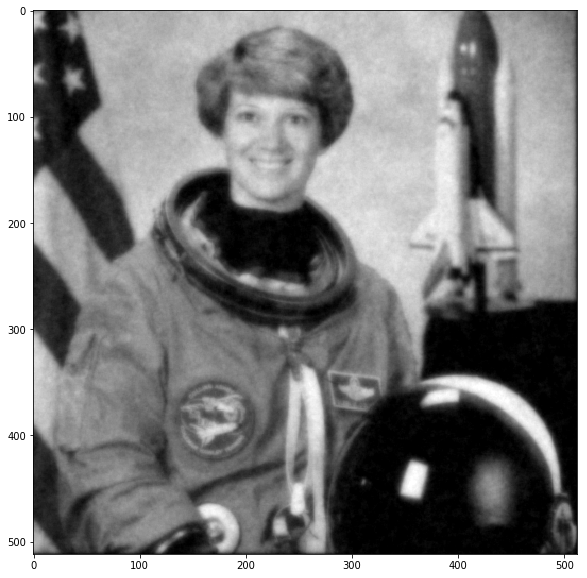

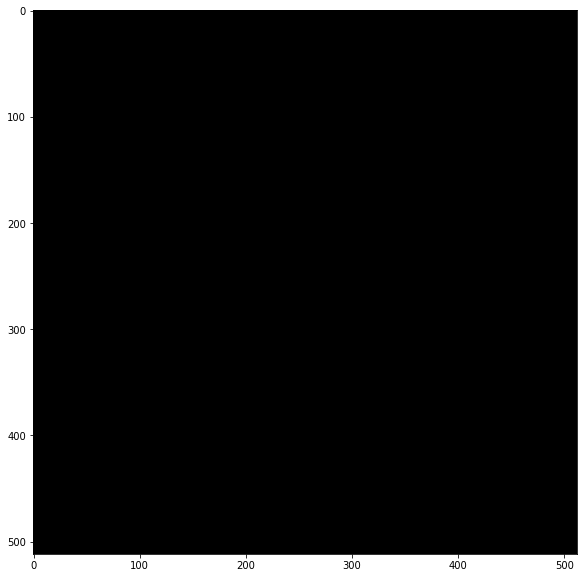

Abs. Diff. between GD-ARM and Linear Solver = 4.292937859418089e-05


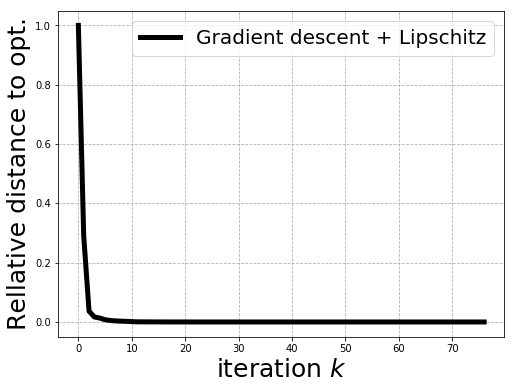

In [60]:
# Plot the relative objective function vs number of iterations. 

rate_arm = (f_vals_arm - f_star) / (f_vals_arm[0] - f_star)

denoised_image_gd_arm = optimized_gd_arm.toarray().reshape((m, n), order='F')
plt.figure(1, figsize=(10, 10))
plt.imshow(denoised_image_gd_arm, cmap='gray', vmin=0, vmax=255)
plt.show()

diff_arm = denoised_image_gd_arm - denoised_image_star
plt.figure(1, figsize=(10, 10))
plt.imshow(diff_arm, cmap='gray', vmin=0, vmax=255)
plt.show()

print(f"Abs. Diff. between GD-ARM and Linear Solver = {np.abs(diff_arm).max()}")

fig = plt.figure(figsize=(8, 6))
plt.plot(rate_arm, label=("Gradient descent + Lipschitz"), linewidth=5.0, color ="black")

plt.legend(prop={'size': 20},loc="upper right")
plt.xlabel("iteration $k$", fontsize=25)
plt.ylabel("Rellative distance to opt.", fontsize=25)
plt.grid(linestyle='dashed')
plt.show()

## Question 6: Is gradient descent with Armijo line-search faster than gradient descent with simple line-search in terms of running time? Is gradient descent with Armijo line-search faster than gradient descent with simple line-search in terms of number of required iterations? Explain any performance differences between the two approaches. Marks: 10

Question breakdown:

#### Is gradient descent with Armijo line-search faster than gradient descent with simple line-search in terms of running time?
Answer

#### Is gradient descent with Armijo line-search faster than gradient descent with simple line-search in terms of number of required iterations? 

Answer 

#### Explain any performance differences between the two approaches.

Answer

## Mathematical Questions

## Question 7: prove that the denoising objective function is strongly convex. What is its strong convexity parameter? Marks: 5

## Question 8: Prove that Armijo line-search will terminate after a finite number of steps. Hint: show that there exists a step-size $$\alpha^*>0$$ such that for any step-size smaller than $$\alpha^*$$ the termination condition of Armijo line-search is satisfied. How many iterations will be required in worst-case for Armijo line-search to terminate? Marks 15

## Question 9: what is the running time for gradient descent with Armijo line-search for the denoising problem to achieve $$f(x_k) - f^* \le \epsilon$$ ?. The running time is computed by multiplying the worst-case iteration complexity times the FLOPS at each iteration. The FLOPS at each iteration is the number of additions, subtractions, multiplications and divisions that are performed during the current iteration. 10

## Question 10: prove the convergence rate and iteration complexity for gradient descent with constant step-sizes (equal to 1/L) for strongly convex functions. Marks: 10